In [1]:
import pandas as pd

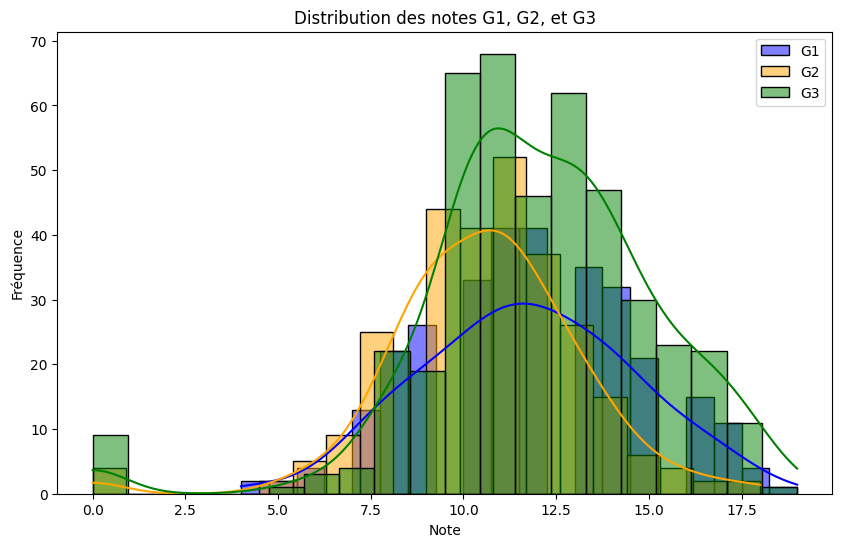

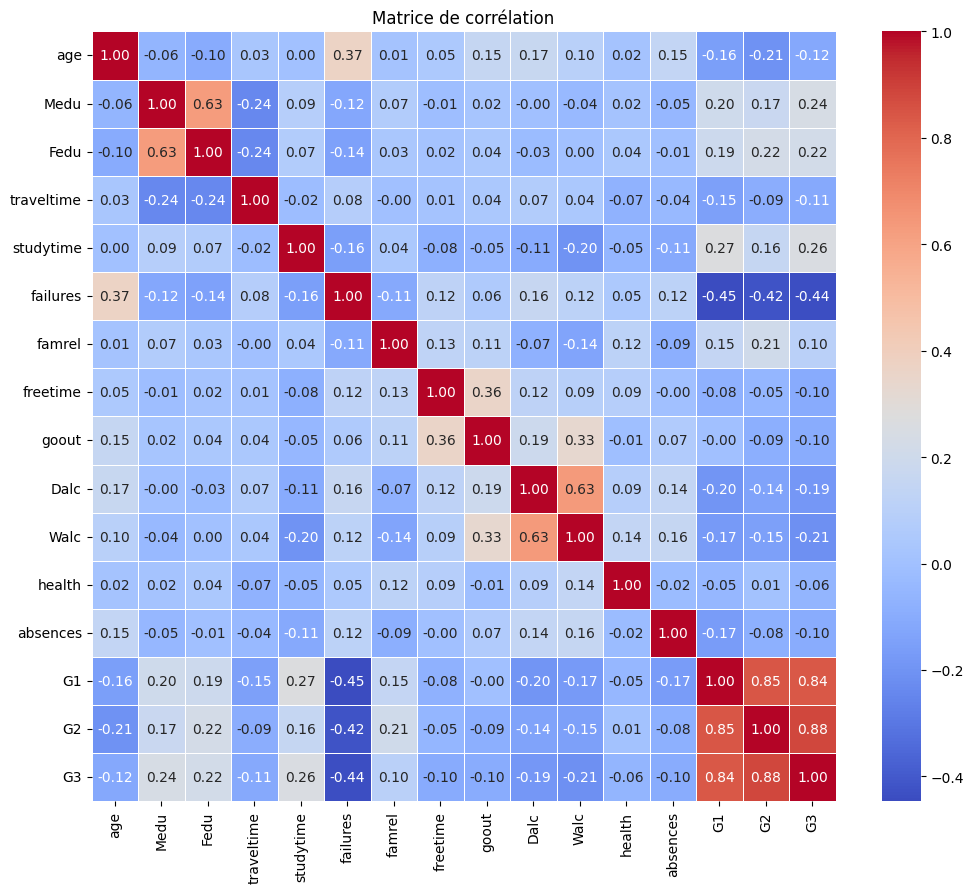

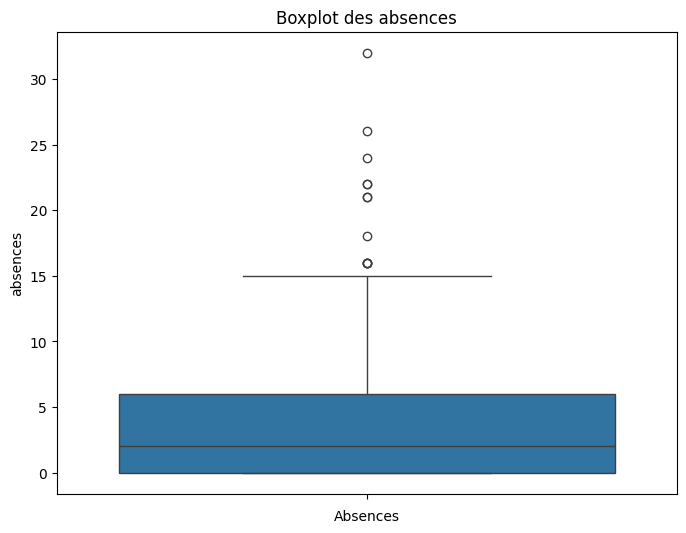

In [199]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données (remplacer 'path_to_your_file.csv' par le chemin de votre fichier)
data = pd.read_csv('data/data_train.csv', delimiter='\t', quotechar='"')

# Figure 1: Distribution des notes G1, G2, G3
plt.figure(figsize=(10, 6))
sns.histplot(data['G1'], kde=True, color='blue', label='G1', bins=20)
sns.histplot(data['G2'], kde=True, color='orange', label='G2', bins=20)
sns.histplot(data['G3'], kde=True, color='green', label='G3', bins=20)
plt.title('Distribution des notes G1, G2, et G3')
plt.xlabel('Note')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

# Sélectionner uniquement les colonnes numériques pour la matrice de corrélation
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = data[numeric_columns].corr()

# Figure 2: Matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de corrélation')
plt.show()

# Figure 3: Boxplot des absences
plt.figure(figsize=(8, 6))
sns.boxplot(data['absences'])
plt.title('Boxplot des absences')
plt.xlabel('Absences')
plt.show()

In [210]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Charger les données
data_train = pd.read_csv('data/data_train.csv', delimiter='\t', quotechar='"')

# Préparer les données pour l'imputation
data_not_null = data_train.dropna(subset=['G1', 'G2'])

# Modèle pour imputer G1 en utilisant G2
model_G1 = LinearRegression()
model_G1.fit(data_not_null[['G2']], data_not_null['G1'])

# Modèle pour imputer G2 en utilisant G1
model_G2 = LinearRegression()
model_G2.fit(data_not_null[['G1']], data_not_null['G2'])

# Imputer G1 pour les valeurs manquantes en utilisant G2
missing_G1 = data_train['G1'].isnull() & data_train['G2'].notnull()
data_train.loc[missing_G1, 'G1'] = model_G1.predict(data_train.loc[missing_G1, ['G2']])

# Imputer G2 pour les valeurs manquantes en utilisant G1
missing_G2 = data_train['G2'].isnull() & data_train['G1'].notnull()
data_train.loc[missing_G2, 'G2'] = model_G2.predict(data_train.loc[missing_G2, ['G1']])

# Supprimer les lignes avec des valeurs manquantes restantes
data_train = data_train.dropna(subset=['G1', 'G2'])



# Imputer les valeurs manquantes restantes avec la moyenne
# data_train['G1'].fillna(data_train['G1'].mean(), inplace=True)
# data_train['G2'].fillna(data_train['G2'].mean(), inplace=True)
data_train_cleaned = data_train

# Convertir les variables catégoriques en variables numériques (encodage one-hot)
data_train_encoded = pd.get_dummies(data_train_cleaned, drop_first=True)

display(data_train_encoded.columns)

# Créer une nouvelle colonne pour la consommation totale d'alcool
data_train_encoded['Total_Alcohol_Consumption'] = data_train_encoded['Walc'] + data_train_encoded['Dalc']
data_train_encoded['Combined_G1_G2'] = data_train_encoded['G1'] + data_train_encoded['G2']
data_train_encoded['Study_Failures_Interaction'] = data_train_encoded['studytime'] * data_train_encoded['failures']
data_train_encoded['Parent_Education'] = data_train_encoded['Medu'] + data_train_encoded['Fedu']
data_train_encoded['Absences_Health_Interaction'] = data_train_encoded['absences'] * data_train_encoded['health']
data_train_encoded['Family_Dynamics'] = data_train_encoded['famsize_LE3'] * data_train_encoded['famrel']
data_train_encoded['Study_Activities_Interaction'] = data_train_encoded['activities_yes'] * data_train_encoded['studytime']
data_train_encoded['Health_Alcohol_Interaction'] = data_train_encoded['health'] * data_train_encoded['Dalc']
data_train_encoded['Travel_Effect'] = data_train_encoded['address_U'] * data_train_encoded['traveltime']
data_train_encoded['Combined_Parent_Education'] = data_train_encoded['Medu'] * data_train_encoded['Fedu']

# Sélectionner manuellement les features basées sur l'analyse de corrélation
# On suppose ici que les colonnes d'intérêt sont encore présentes après encodage
selected_features = [col for col in data_train_encoded.columns if col in ['G1', 'G2', 'studytime', 'Medu', 'Fedu', 'Walc', 'Dalc', 'Absences_Health_Interaction', 'Family_Dynamics', 'Health_Alcohol_Interaction', 'Travel_Effect']]

# Ajouter les nouvelles colonnes encodées manuellement si besoin
selected_features.extend([col for col in data_train_encoded.columns if col.startswith('school_') or col.startswith('sex_')])

# Séparer les données en ensembles d'entraînement et de test
X_encoded = data_train_encoded[selected_features]
y_encoded = data_train_encoded['G3']


# scaler = StandardScaler()
# X_encoded = scaler.fit_transform(X_encoded)
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# models = {
#     'Ridge': Ridge(),
#     'Lasso': Lasso(),
#     'XGBoost': xgb.XGBRegressor(),
#     'LightGBM': lgb.LGBMRegressor()
# }
# # Évaluer chaque modèle
# for name, model in models.items():
#     model.fit(X_train_encoded, y_train_encoded)
#     y_pred = model.predict(X_test_encoded)
#     mse = mean_squared_error(y_test_encoded, y_pred)
#     r2 = r2_score(y_test_encoded, y_pred)
#     print(f"{name} - Mean Squared Error: {mse:.4f}, R-squared: {r2:.4f}")

# # Créer et entraîner le modèle de régression linéaire
# model_encoded = LinearRegression()
# model_encoded.fit(X_train_encoded, y_train_encoded)

# # Faire des prédictions sur l'ensemble de test
# y_pred_encoded = model_encoded.predict(X_test_encoded)

# # Évaluer le modèle
# mse_encoded = mean_squared_error(y_test_encoded, y_pred_encoded)
# r2_encoded = r2_score(y_test_encoded, y_pred_encoded)

# print(f'Mean Squared Error: {mse_encoded}')
# print(f'R-squared: {r2_encoded}')

# Créer le modèle de régression linéaire
model_lr = LinearRegression()

# Utiliser la validation croisée pour évaluer le modèle
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
cv_scores = cross_val_score(model_lr, X_encoded, y_encoded, cv=10, scoring=mse_scorer)

# Calculer la moyenne et l'écart type de la MSE pour évaluer la performance
mean_mse = -cv_scores.mean()
std_mse = cv_scores.std()

print(f'Mean MSE from cross-validation: {mean_mse:.4f}')
print(f'Standard Deviation of MSE: {std_mse:.4f}')

# Entraîner le modèle sur l'ensemble complet des données d'entraînement
model_lr.fit(X_encoded, y_encoded)


Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'schoolsup_yes', 'famsup_yes', 'paid_yes',
       'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes',
       'romantic_yes'],
      dtype='object')

Mean MSE from cross-validation: 1.9323
Standard Deviation of MSE: 1.0149


LinearRegression()

In [217]:
data_test = pd.read_csv('data/data_test.csv', delimiter='\t', quotechar='"')

display(data_test)

# Encodage des variables catégoriques dans data_test en utilisant le même encodage que pour data_train_cleaned
X_test_encoded = pd.get_dummies(data_test, drop_first=True)

# Assurer que les colonnes dans X_test_encoded correspondent à celles dans X_encoded (qui a été utilisé pour entraîner le modèle)
missing_cols = set(X_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0

# Réordonner les colonnes pour correspondre à l'ordre de X_encoded
X_test_encoded = X_test_encoded[X_encoded.columns]

# Faire des prédictions sur data_test
y_test_pred = model_lr.predict(X_test_encoded)

y_test_pred

school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
434     GP   F   18       U     GT3       A     4     4   at_home   teacher   
435     GP   F   17       U     GT3       T     1     1   at_home     other   
436     GP   F   15       U     LE3       T     1     1   at_home     other   
437     GP   M   15       U     LE3       A     3     2  services     other   
438     GP   M   15       U     GT3       A     2     2     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
645     MS   M   19       R     GT3       T     1     1     other  services   
646     MS   F   18       R     GT3       T     2     2   at_home     other   
647     MS   F   18       R     GT3       T     4     4   teacher   at_home   
648     MS   F   18       U     LE3       T     3     1   teacher  services   
649     MS   F   18       U     GT3       T     1     1     other     other   

     ... romantic famrel  freetime  goout  Dalc Walc health absences  G1  G2  
434  ...       no      4         3      4     1    1      3        4   0  11  
435  ...       no      5         3      3     1    1      3        2   9  11  
436  ...       no      4         3      2     2    3      3        6  12  13  
437  ...       no      4         2      2     1    1      1        0  15  16  
438  ...      yes      4         5      2     1    1      3        0  14  14  
..   ...      ...    ...       ...    ...   ...  ...    ...      ...  ..  ..  
645  ...       no      4         3      2     1    3      5        0   5   8  
646  ...       no      5         3      3     1    3      4        0  14  17  
647  ...      yes      4         4      3     2    2      5        4   7   9  
648  ...       no      4         3      4     1    1      1        4  15  15  
649  ...       no      1         1      1     1    1      5        6  11  12  

[216 rows x 32 columns]

array([10.01060363, 11.04395656, 13.0783047 , 16.35071974, 14.47594424,
       13.57744919, 14.40190512, 12.24474449, 11.01516037, 12.26842845,
       10.98786884, 15.42396932, 10.05739261, 11.29501797,  8.99611011,
       13.2549924 , 15.55773443, 15.65663771, 16.62686274,  9.7014604 ,
       12.3793357 ,  9.46930017, 11.65208064, 11.46868631,  9.10108936,
        9.43182433, 11.44270487, 15.49767481, 13.47355334, 12.33724609,
       11.02091101, 12.48569105, 13.30622386,  8.76355018, 16.66329612,
       10.43240676, 12.73220259, 13.14068422,  9.0591389 , 11.28726113,
        9.28126843, 10.29633384, 11.56713127, 14.5274796 , 13.51891505,
       11.25782504, 10.10911558,  9.03532842, 11.22710134, 12.30135441,
        9.18886265,  8.10569636, 10.15183442,  9.93838367,  9.90607865,
       17.59653574, 12.40516273,  9.51034732,  9.40653901, 11.35717135,
        9.23751974, 11.4452519 , 10.0825709 , 15.25377083, 10.53198947,
       12.23070651, 11.19258576, 11.21044045,  9.40260609, 13.15

In [218]:
len(y_test_pred)

216

In [178]:
predictions_valid_rounded = [round(prediction) for prediction in y_test_pred]
print(predictions_valid_rounded)

[10, 11, 13, 16, 14, 14, 14, 12, 11, 12, 11, 15, 10, 11, 9, 13, 16, 16, 17, 10, 12, 9, 12, 11, 9, 9, 11, 15, 13, 12, 11, 12, 13, 9, 17, 10, 13, 13, 9, 11, 9, 10, 12, 15, 14, 11, 10, 9, 11, 12, 9, 8, 10, 10, 10, 18, 12, 10, 9, 11, 9, 11, 10, 15, 11, 12, 11, 11, 9, 13, 17, 11, 13, 13, 9, 10, 8, 7, 10, 9, 7, 15, 15, 15, 11, 14, 8, 11, 12, 13, 10, 12, 11, 13, 12, 16, 9, 12, 13, 10, 10, 13, 13, 13, 12, 19, 13, 15, 15, 14, 18, 12, 12, 15, 8, 10, 14, 18, 10, 15, 12, 11, 15, 14, 12, 16, 12, 15, 16, 11, 14, 17, 17, 10, 6, 16, 0, 10, 9, 11, 13, 11, 10, 8, 12, 11, 8, 12, 13, 8, 11, 10, 7, 10, 10, 9, 11, 8, 10, 14, 6, 17, 9, 6, 14, 8, 10, 14, 9, 11, 9, 11, 13, 11, 10, 11, 11, 18, 9, 11, 12, 9, 7, 8, 8, 11, 7, 8, 13, 13, 10, 13, 1, 0, 11, 14, 10, 13, 15, 13, 10, 16, 8, 10, 5, 10, 11, 14, 9, 18, 7, 7, 17, 9, 15, 12]


In [215]:
len(predictions_valid_rounded)

216

In [113]:
listdf = [11, 11, 12, 17, 15, 14, 14, 12, 11, 12, 11, 15, 10, 11, 9, 12, 16, 16, 16, 16, 12, 10, 11, 11, 10, 9, 12, 15, 13, 12, 11, 12, 13, 8, 16, 11, 13, 13, 9, 12, 8, 11, 11, 15, 13, 11, 10, 9, 11, 12, 8, 8, 11, 1, 11, 18, 13, 10, 10, 13, 11, 12, 10, 16, 11, 12, 12, 11, 10, 13, 16, 11, 13, 13, 9, 10, 10, 7, 10, 8, 8, 15, 15, 15, 12, 15, 7, 10, 14, 14, 10, 12, 12, 13, 13, 16, 10, 12, 13, 10, 11, 13, 13, 14, 12, 18, 14, 15, 15, 13, 17, 14, 14, 17, 9, 10, 15, 17, 10, 15, 11, 12, 15, 16, 14, 17, 13, 15, 16, 11, 15, 17, 17, 11, 7, 16, 0, 11, 9, 11, 13, 11, 11, 8, 12, 11, 8, 13, 12, 10, 11, 11, 8, 11, 10, 9, 10, 9, 10, 14, 7, 18, 10, 8, 15, 8, 10, 14, 9, 11, 9, 10, 12, 11, 10, 11, 12, 18, 10, 12, 10, 10, 9, 8, 7, 11, 8, 7, 14, 14, 11, 14, 0, 0, 12, 15, 10, 14, 15, 13, 9, 16, 9, 10, 0, 10, 12, 14, 9, 19, 0, 0, 15, 10, 16, 9]

In [190]:
listdf2 = [
    11, 11, 13, 16, 14, 13, 14, 12, 11, 12, 11, 15, 10, 11, 9, 13, 15, 15, 16, 10, 12, 9, 11, 11, 9, 9, 11, 15, 13, 12,
    11, 12, 13, 9, 16, 10, 12, 13, 9, 11, 9, 10, 11, 14, 13, 11, 10, 9, 11, 12, 9, 8, 10, 10, 10, 17, 12, 9, 9, 11, 9, 
    11, 10, 15, 10, 12, 11, 11, 9, 13, 16, 11, 13, 13, 9, 10, 8, 7, 10, 9, 7, 14, 15, 15, 11, 14, 8, 11, 12, 13, 10, 12, 
    11, 12, 12, 16, 9, 12, 13, 10, 10, 13, 13, 13, 12, 18, 13, 15, 15, 13, 18, 12, 12, 15, 8, 10, 14, 18, 10, 14, 12, 11, 
    14, 14, 12, 16, 12, 15, 16, 11, 14, 17, 17, 11, 6, 16, 0, 10, 9, 11, 13, 11, 10, 8, 11, 11, 8, 12, 12, 8, 11, 10, 7, 
    10, 10, 9, 11, 8, 10, 14, 7, 17, 9, 6, 14, 8, 10, 14, 9, 11, 10, 11, 13, 11, 10, 11, 11, 18, 9, 11, 13, 9, 7, 8, 8, 
    11, 7, 8, 13, 13, 11, 13, 0, 0, 11, 14, 10, 13, 15, 13, 10, 16, 8, 10, 5, 10, 11, 14, 9, 18, 7, 8, 17, 9, 15, 12
]

In [191]:
listdf3 = [11, 11, 20, 17, 15, 14, 14, 12, 11, 12, 11, 15, 10, 11, 9, 0, 16, 16, 16, 16, 12, 10, 11, 11, 10, 9, 12, 15, 13, 12, 11, 12, 20, 8, 16, 11, 13, 13, 9, 12, 20, 11, 11, 15, 13, 11, 10, 9, 11, 12, 8, 8, 11, 1, 11, 18, 13, 10, 10, 13, 11, 12, 10, 16, 11, 12, 12, 11, 10, 13, 16, 11, 13, 13, 9, 10, 10, 7, 10, 8, 8, 15, 15, 15, 12, 15, 7, 10, 14, 14, 10, 12, 12, 13, 13, 16, 10, 12, 13, 10, 11, 13, 13, 14, 12, 18, 14, 15, 15, 13, 17, 14, 14, 17, 9, 10, 15, 17, 10, 15, 11, 12, 15, 16, 14, 17, 13, 15, 16, 11, 15, 17, 17, 11, 7, 16, 0, 11, 9, 11, 13, 11, 11, 8, 12, 11, 8, 13, 12, 10, 11, 11, 8, 11, 10, 9, 10, 9, 10, 14, 7, 18, 10, 8, 15, 8, 10, 14, 9, 11, 9, 10, 12, 11, 10, 11, 12, 18, 10, 12, 10, 10, 9, 8, 8, 11, 8, 7, 14, 14, 11, 14, 0, 0, 12, 15, 10, 14, 15, 13, 9, 16, 9, 10, 0, 10, 12, 14, 9, 19, 0, 0, 15, 10, 16, 9]

In [219]:
def mean_squared_error(y_pred, y_test):
    """
    Calculer l'erreur quadratique moyenne (MSE) entre deux listes de valeurs.

    :param y_pred: Liste des valeurs prédictes
    :param y_test: Liste des valeurs réelles
    :return: Erreur quadratique moyenne (MSE)
    """
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    mse = np.mean((y_pred - y_test) ** 2)
    # mse = mean_squared_error(y_test, y_pred)
    return mse

# Exemple d'utilisation
y_pred = y_test_pred  # Valeurs prédictes
y_test = listdf2  # Valeurs réelles

mse_result = mean_squared_error(y_pred, y_test)
print(f"Erreur quadratique moyenne (MSE): {mse_result}")

Erreur quadratique moyenne (MSE): 0.11335691143173433


In [220]:
df = pd.DataFrame(y_test_pred)
df.to_csv('my_pred.csv', index=False)

In [188]:
display(pd.read_csv("my_pred.csv", header=None))


0
0     0.000000
1    10.010604
2    11.043957
3    13.078305
4    16.350720
..         ...
212   7.477452
213  17.074853
214   8.858006
215  15.378054
216  12.126579

[217 rows x 1 columns]